# compile and postprocess subhalos from morphology data Connor constructed

In [1]:
import os
import numpy as np 
from astropy import table as aTable

In [2]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# load subhalo and morphy data in G, I, R, Y, Z bands

In [3]:
dat_dir = '/Users/chahah/data/frb_halos/'

morph_g = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_G.csv'))
morph_i = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_I.csv'))
morph_r = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_R.csv'))
morph_y = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Y.csv'))
morph_z = aTable.Table.read(os.path.join(dat_dir, 'MorphSersic_HSC_Z.csv'))

subhalo = aTable.Table.read(os.path.join(dat_dir, 'Subhalos.csv'))

In [4]:
print('%i morphology' % len(morph_g))
print('%i subhalos' % len(subhalo))

78849 morphology
187978 subhalos


In [5]:
subhalo.columns

<TableColumns names=('dbID','SnapNum','SubfindID','SubhaloMassType_stars','SubhaloMassType_gas','SubhaloMassType_dm','SubhaloMassInRadType_stars','SubhaloMassInRadType_gas','SubhaloMassInRadType_dm','SubhaloMassInHalfRadType_stars','SubhaloMassInHalfRadType_gas','SubhaloMassInHalfRadType_dm','SubhaloHalfMassRadType_stars','SubhaloHalfMassRadType_gas','SubhaloHalfMassRadType_dm','SubhaloSFR','SubhaloSFRinRad','SubhaloSFRinHalfRad')>

# compile morphology

In [6]:
for morph in [morph_g, morph_i, morph_r, morph_y, morph_z]:
    morph['snapshot'] = [int(dbid.split('_')[1]) for dbid in morph['dbID'].data]
    morph['subhalo_id'] = [int(dbid.split('_')[2]) for dbid in morph['dbID'].data]
    morph['version'] = [dbid.split('_')[3] for dbid in morph['dbID'].data]

In [7]:
col_photo = ['Sersic_mag', 'Sersic_Reff', 'CAS_C', 'CAS_A', 'Sersic_dmag_m', 'Sersic_dmag_p']
col_subhalo = ['SubhaloMassType_stars']

In [8]:
for band, morph in zip(['g', 'i', 'r', 'y', 'z'], [morph_g, morph_i, morph_r, morph_y, morph_z]): 
    cols = morph.columns.copy()
    for k in cols: 
        if k in col_photo: 
            morph.rename_column(k, '%s_%s' % (band, k))
        elif k in ['snapshot', 'subhalo_id', 'version']: 
            pass
        else: 
            morph.remove_column(k)

In [9]:
for i, morph in enumerate([morph_g, morph_i, morph_r, morph_y, morph_z]): 
    mask = np.zeros(len(morph)).astype(bool)
    for k in morph.columns: 
        try: 
            mask = mask | morph[k].mask
        except AttributeError: 
            pass
        
    if i == 0: 
        morphs = morph.copy()
    else:        
        morphs = aTable.join(morphs, morph[~mask], keys=['snapshot', 'subhalo_id', 'version'], join_type='left')

In [10]:
mask = np.zeros(len(morphs)).astype(bool)
for k in morphs.columns: 
    try: 
        mask = mask | morphs[k].mask
    except AttributeError: 
        pass
morphs = morphs[~mask]

In [11]:
morphs.write(os.path.join(dat_dir, 'MorphSersic_HSC_combined.csv'), overwrite=True)

In [12]:
len(morphs)

78326

# match morphology to subhalos

In [13]:
subhalo['snapshot'] = [int(dbid.split('_')[0]) for dbid in subhalo['dbID'].data]
subhalo['subhalo_id'] = [int(dbid.split('_')[1]) for dbid in subhalo['dbID'].data]

In [14]:
combined = aTable.join(morphs, subhalo['snapshot', 'subhalo_id', 'SubhaloMassType_stars', 'SubhaloMassType_dm'], 
                       keys=['snapshot', 'subhalo_id'], join_type='left')

In [15]:
len(combined)

78326

In [16]:
combined[:10]

g_Sersic_Reff,g_Sersic_mag,g_Sersic_dmag_m,g_Sersic_dmag_p,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_Sersic_dmag_m,i_Sersic_dmag_p,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_Sersic_dmag_m,r_Sersic_dmag_p,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_Sersic_dmag_m,y_Sersic_dmag_p,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_Sersic_dmag_m,z_Sersic_dmag_p,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.24613,19.1778,-0.0779797,0.046892,3.33779,0.27015,59,0,v0,1.99236,17.9386,-0.00174236,0.00182266,4.5414,0.239801,5.28233,18.5249,-0.00385797,0.00355385,3.97973,0.239256,1.37891,17.5674,-0.00361839,0.00339944,4.18415,0.112956,1.97202,17.6489,-0.00287083,0.00251571,4.20004,0.154838,12.1272,13.8103
11.6712,19.0432,-0.0425542,0.0731264,3.22296,0.364432,59,0,v1,6.57865,17.6822,-0.00529423,0.00438403,4.48597,0.292787,4.46632,18.8765,-0.0472835,0.012885,3.87586,0.250358,2.25006,17.5264,-0.00579206,0.0070568,4.22799,0.12975,2.76786,17.6744,-0.00346853,0.0040452,4.91712,0.22512,12.1272,13.8103
6.29045,19.1097,-0.0219538,0.0249799,3.24656,0.390166,59,0,v3,1.2414,17.9188,-0.00291304,0.00337726,4.72038,0.247056,5.83477,18.22,-0.00423978,0.00453768,4.37358,0.194555,0.793874,17.6673,-0.00662935,0.00673421,3.72926,0.0387591,1.3203,17.594,-0.00594847,0.0057911,4.17379,0.122474,12.1272,13.8103
6.1195,19.7286,-0.00522288,0.00495322,2.82971,0.410775,59,0,v2,3.60767,18.5171,-0.0027119,0.00272167,3.21209,0.263637,4.69163,19.2032,-0.00338622,0.00370766,2.96856,0.347073,2.45257,18.3693,-0.00816445,0.00805607,2.72622,0.343008,3.19436,18.3335,-0.00432735,0.00447652,3.22296,0.294881,12.1272,13.8103
1.09169,21.8644,-0.0166642,0.0164959,2.7975,0.0526816,59,1,v0,2.78929,18.8237,-0.0116263,0.0114589,3.74536,0.0654512,1.72633,20.2486,-0.0190367,0.0413142,3.45521,0.0714894,1.54465,18.4721,-0.0257487,0.0244008,3.30828,-0.0680968,2.2398,18.5473,-0.0189426,0.0166284,3.54191,0.0137252,11.6411,12.2768
2.01967,22.1402,-0.0182377,0.0191319,2.55991,0.0574513,59,1,v1,1.68262,19.8838,-0.00329594,0.00364306,2.73725,0.0538379,1.82228,20.9623,-0.00867535,0.00895086,2.66172,0.0414195,1.65344,19.2729,-0.0085207,0.00891479,2.73725,0.216853,1.66276,19.5076,-0.00449916,0.00489813,2.73725,0.0284926,11.6411,12.2768
1.67424,22.449,-0.0196103,0.0201925,2.27646,0.167663,59,1,v3,1.78928,20.0178,-0.00478747,0.00484713,2.75523,0.0133046,1.71886,21.1652,-0.00876313,0.00848837,2.4659,-0.0030618,1.71543,19.3825,-0.00932667,0.00933528,2.74643,-0.00537999,1.72827,19.6277,-0.005315,0.00574983,2.65343,0.0163783,11.6411,12.2768
1.34947,21.8735,-0.0261805,0.0247424,3.24705,0.00615523,59,1,v2,3.01319,18.8955,-0.00521275,0.00494419,3.62786,0.0529701,1.45964,20.544,-0.0410585,0.0145966,3.15136,0.0252437,1.88951,18.4644,-0.015482,0.0155955,3.59464,0.00589105,2.61851,18.5542,-0.0112939,0.0143721,3.54191,0.0412003,11.6411,12.2768
0.886459,22.2643,-0.0139017,0.0132067,2.60025,0.0542663,59,2,v3,0.630245,19.8825,-0.00760746,0.00736855,3.33662,0.0425929,0.768033,21.005,-0.0125529,0.0122152,3.12665,0.00693228,0.449218,19.424,-0.0166878,0.0133327,2.91414,-0.028555,0.508829,19.5809,-0.0085195,0.00818083,3.04156,0.0232522,11.4885,12.1219


In [17]:
combined = combined[combined['SubhaloMassType_dm'] > 0]

In [18]:
cols = list(combined.dtype.names)
cols.remove('snapshot')
cols.remove('subhalo_id')
cols.remove('version')

IndexError: list index out of range

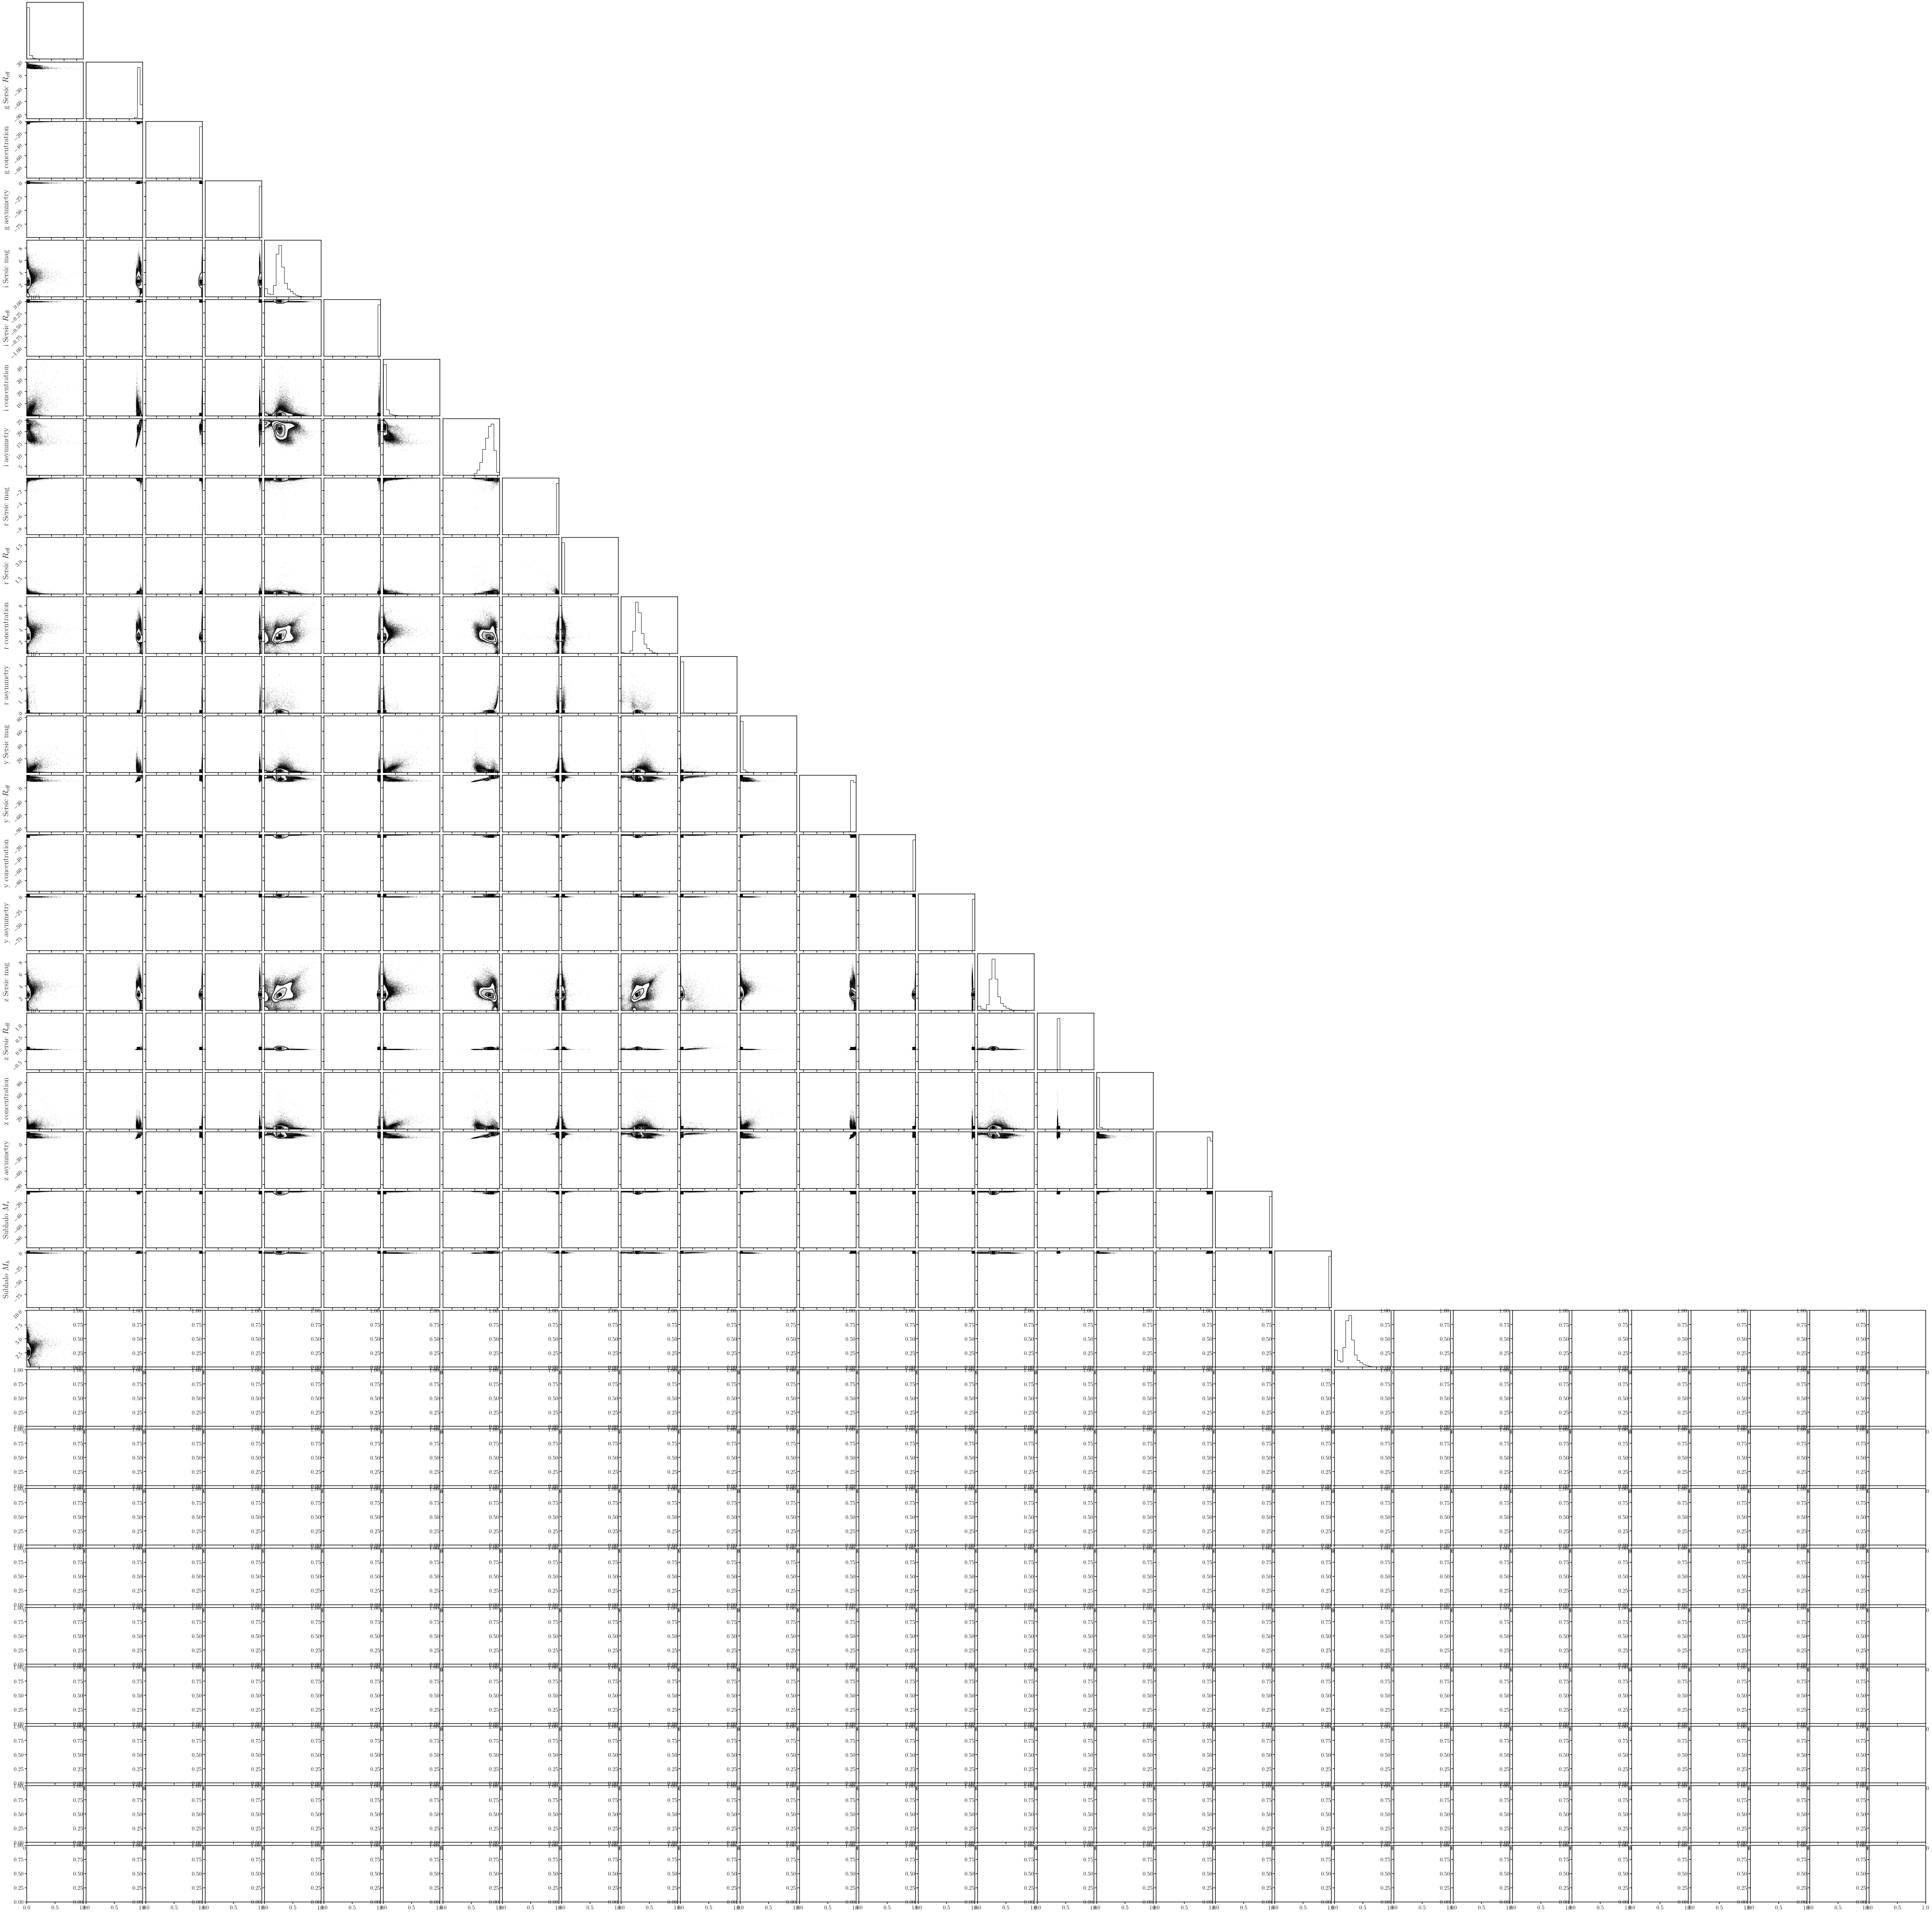

In [19]:
fig = DFM.corner(np.array([np.array(combined[col].data) for col in cols]).T, 
                 labels=['g Sersic mag', r'g Sersic $R_{\rm eff}$', r'g concentration', r'g asymmetry', 
                         'i Sersic mag', r'i Sersic $R_{\rm eff}$', r'i concentration', r'i asymmetry', 
                         'r Sersic mag', r'r Sersic $R_{\rm eff}$', r'r concentration', r'r asymmetry', 
                         'y Sersic mag', r'y Sersic $R_{\rm eff}$', r'y concentration', r'y asymmetry', 
                         'z Sersic mag', r'z Sersic $R_{\rm eff}$', r'z concentration', r'z asymmetry', 
                         r'Subhalo $M_*$', r'Subhalo $M_h$'], 
                 label_kwargs={'fontsize': 20})

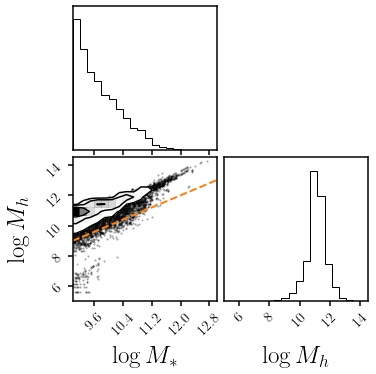

In [22]:
fig = DFM.corner(np.array([np.array(combined[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T, 
               range=[(9., 13.), (5., 14.5)],
              labels=[r'$\log M_*$', r'$\log M_h$'],
              label_kwargs={'fontsize': 25})
fig.axes[2].plot([9., 13.], [9., 13.], c='C1', ls='--', linewidth=2)

In [23]:
combined[:5]

g_Sersic_Reff,g_Sersic_mag,g_Sersic_dmag_m,g_Sersic_dmag_p,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_Sersic_dmag_m,i_Sersic_dmag_p,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_Sersic_dmag_m,r_Sersic_dmag_p,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_Sersic_dmag_m,y_Sersic_dmag_p,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_Sersic_dmag_m,z_Sersic_dmag_p,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8.24613,19.1778,-0.0779797,0.046892,3.33779,0.27015,59,0,v0,1.99236,17.9386,-0.00174236,0.00182266,4.5414,0.239801,5.28233,18.5249,-0.00385797,0.00355385,3.97973,0.239256,1.37891,17.5674,-0.00361839,0.00339944,4.18415,0.112956,1.97202,17.6489,-0.00287083,0.00251571,4.20004,0.154838,12.1272,13.8103
11.6712,19.0432,-0.0425542,0.0731264,3.22296,0.364432,59,0,v1,6.57865,17.6822,-0.00529423,0.00438403,4.48597,0.292787,4.46632,18.8765,-0.0472835,0.012885,3.87586,0.250358,2.25006,17.5264,-0.00579206,0.0070568,4.22799,0.12975,2.76786,17.6744,-0.00346853,0.0040452,4.91712,0.22512,12.1272,13.8103
6.29045,19.1097,-0.0219538,0.0249799,3.24656,0.390166,59,0,v3,1.2414,17.9188,-0.00291304,0.00337726,4.72038,0.247056,5.83477,18.22,-0.00423978,0.00453768,4.37358,0.194555,0.793874,17.6673,-0.00662935,0.00673421,3.72926,0.0387591,1.3203,17.594,-0.00594847,0.0057911,4.17379,0.122474,12.1272,13.8103
6.1195,19.7286,-0.00522288,0.00495322,2.82971,0.410775,59,0,v2,3.60767,18.5171,-0.0027119,0.00272167,3.21209,0.263637,4.69163,19.2032,-0.00338622,0.00370766,2.96856,0.347073,2.45257,18.3693,-0.00816445,0.00805607,2.72622,0.343008,3.19436,18.3335,-0.00432735,0.00447652,3.22296,0.294881,12.1272,13.8103
1.09169,21.8644,-0.0166642,0.0164959,2.7975,0.0526816,59,1,v0,2.78929,18.8237,-0.0116263,0.0114589,3.74536,0.0654512,1.72633,20.2486,-0.0190367,0.0413142,3.45521,0.0714894,1.54465,18.4721,-0.0257487,0.0244008,3.30828,-0.0680968,2.2398,18.5473,-0.0189426,0.0166284,3.54191,0.0137252,11.6411,12.2768


In [24]:
combined.write('/Users/chahah/data/frb_halos/subhalos_morph.csv', overwrite=True)